In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date
import proplot as pplt
import sys
import os

# --- Correctly configure paths from within the 'examples' directory ---
# Get the project root directory (which is the parent of the current 'examples' directory)
project_root = os.path.dirname(os.getcwd())

# Add the path to the legacy Oliver code so Python can find it
legacy_code_dir = os.path.join(project_root, 'tests', 'data', 'legacy')
sys.path.append(legacy_code_dir)

# Now we can import everything
import marineHeatWaves as oliver_mhw
from mhw3d import bipolarMhwToolBox as ben_mhw

/Users/neilmalan/miniconda3/envs/mhw3d/lib/python3.10/site-packages/proplot/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


In [2]:
def generate_synthetic_data():
    """
    Generates a synthetic temperature time series based on the example
    in the ecjoliver/marineHeatWaves README.
    """
    # Create time vector
    t_start = date(1982, 1, 1).toordinal()
    t_end = date(2013, 12, 31).toordinal()
    time = np.arange(t_start, t_end + 1)

    # Create synthetic temperature series
    temp = 15. * np.ones(len(time))
    temp += 5. * np.cos(2 * np.pi * (time - 150) / 365.25) # Seasonal cycle
    temp += 0.2 * (time - time[0]) / (time[-1] - time[0]) # Trend
    temp += 0.5 * np.random.randn(len(time)) # Noise
    
    # Add three MHWs
    temp[1000:1050] += 4.0
    temp[4000:4100] += 3.0
    temp[8000:8050] += 5.0

    # Convert ordinal time to datetime64 for xarray/pandas
    time_datetime = np.array([date.fromordinal(t) for t in time]).astype('datetime64[ns]')

    return time_datetime, temp

## First we check that the detection algorithms produce exactly the same results (applying the benMHW detection to the Oliver thresholds)

In [3]:
# 1. Generate the data
time, temp = generate_synthetic_data()

# 2. Run the original Oliver code
t_ordinal = np.array([pd.to_datetime(t).to_pydatetime().toordinal() for t in time])
expected_events, expected_clim = oliver_mhw.detect(t_ordinal, temp)
expected_df = pd.DataFrame(expected_events)

# 3. Prepare input for YOUR toolbox
ssta = temp - expected_clim['seas']
severity = ssta / (expected_clim['thresh'] - expected_clim['seas'])

# 4. Create the xarray.Dataset for your code
ds_input_1d = xr.Dataset(
    data_vars={'ssta': (('time',), ssta), 'severity': (('time',), severity)},
    coords={'time': time}
)
ds_input = ds_input_1d.expand_dims(['lat', 'lon'])

# 5. Run YOUR code
ds_actual_events = ben_mhw.calculate_MHWs_metrics(ds_input)

# 6. Format your results into a clean DataFrame
ds_actual_events = ds_actual_events.squeeze(drop=True).dropna('event', how='all')
actual_df = pd.DataFrame({
    'date_start': ds_actual_events['date_start'].values,
    'date_end': ds_actual_events['date_end'].values,
    'date_peak': ds_actual_events['date_peak'].values,
    'duration': ds_actual_events['duration'].values,
    'intensity_max': ds_actual_events['intensity_max'].values,
    'intensity_mean': ds_actual_events['intensity_mean'].values,
    'intensity_cumulative': ds_actual_events['intensity_cumul'].values,
})


In [4]:
# Select only the columns we want to compare
columns_to_compare = actual_df.columns.tolist()

print("--- Expected Events (Oliver Method) ---")
display(expected_df[columns_to_compare])

print("\n--- Actual Events (Ben-MHW Method) ---")
display(actual_df)

--- Expected Events (Oliver Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-11-09,50,5.034780,3.807842,190.392110
1,1992-12-14,1993-03-23,1993-01-12,100,4.007708,2.808488,280.848778
2,2003-11-27,2004-01-15,2003-12-24,50,5.672080,4.825916,241.295817



--- Actual Events (Ben-MHW Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-11-09,50.0,5.034780,3.807842,190.392110
1,1992-12-14,1993-03-23,1993-01-12,100.0,4.007708,2.808488,280.848778
2,2003-11-27,2004-01-15,2003-12-24,50.0,5.672080,4.825916,241.295817


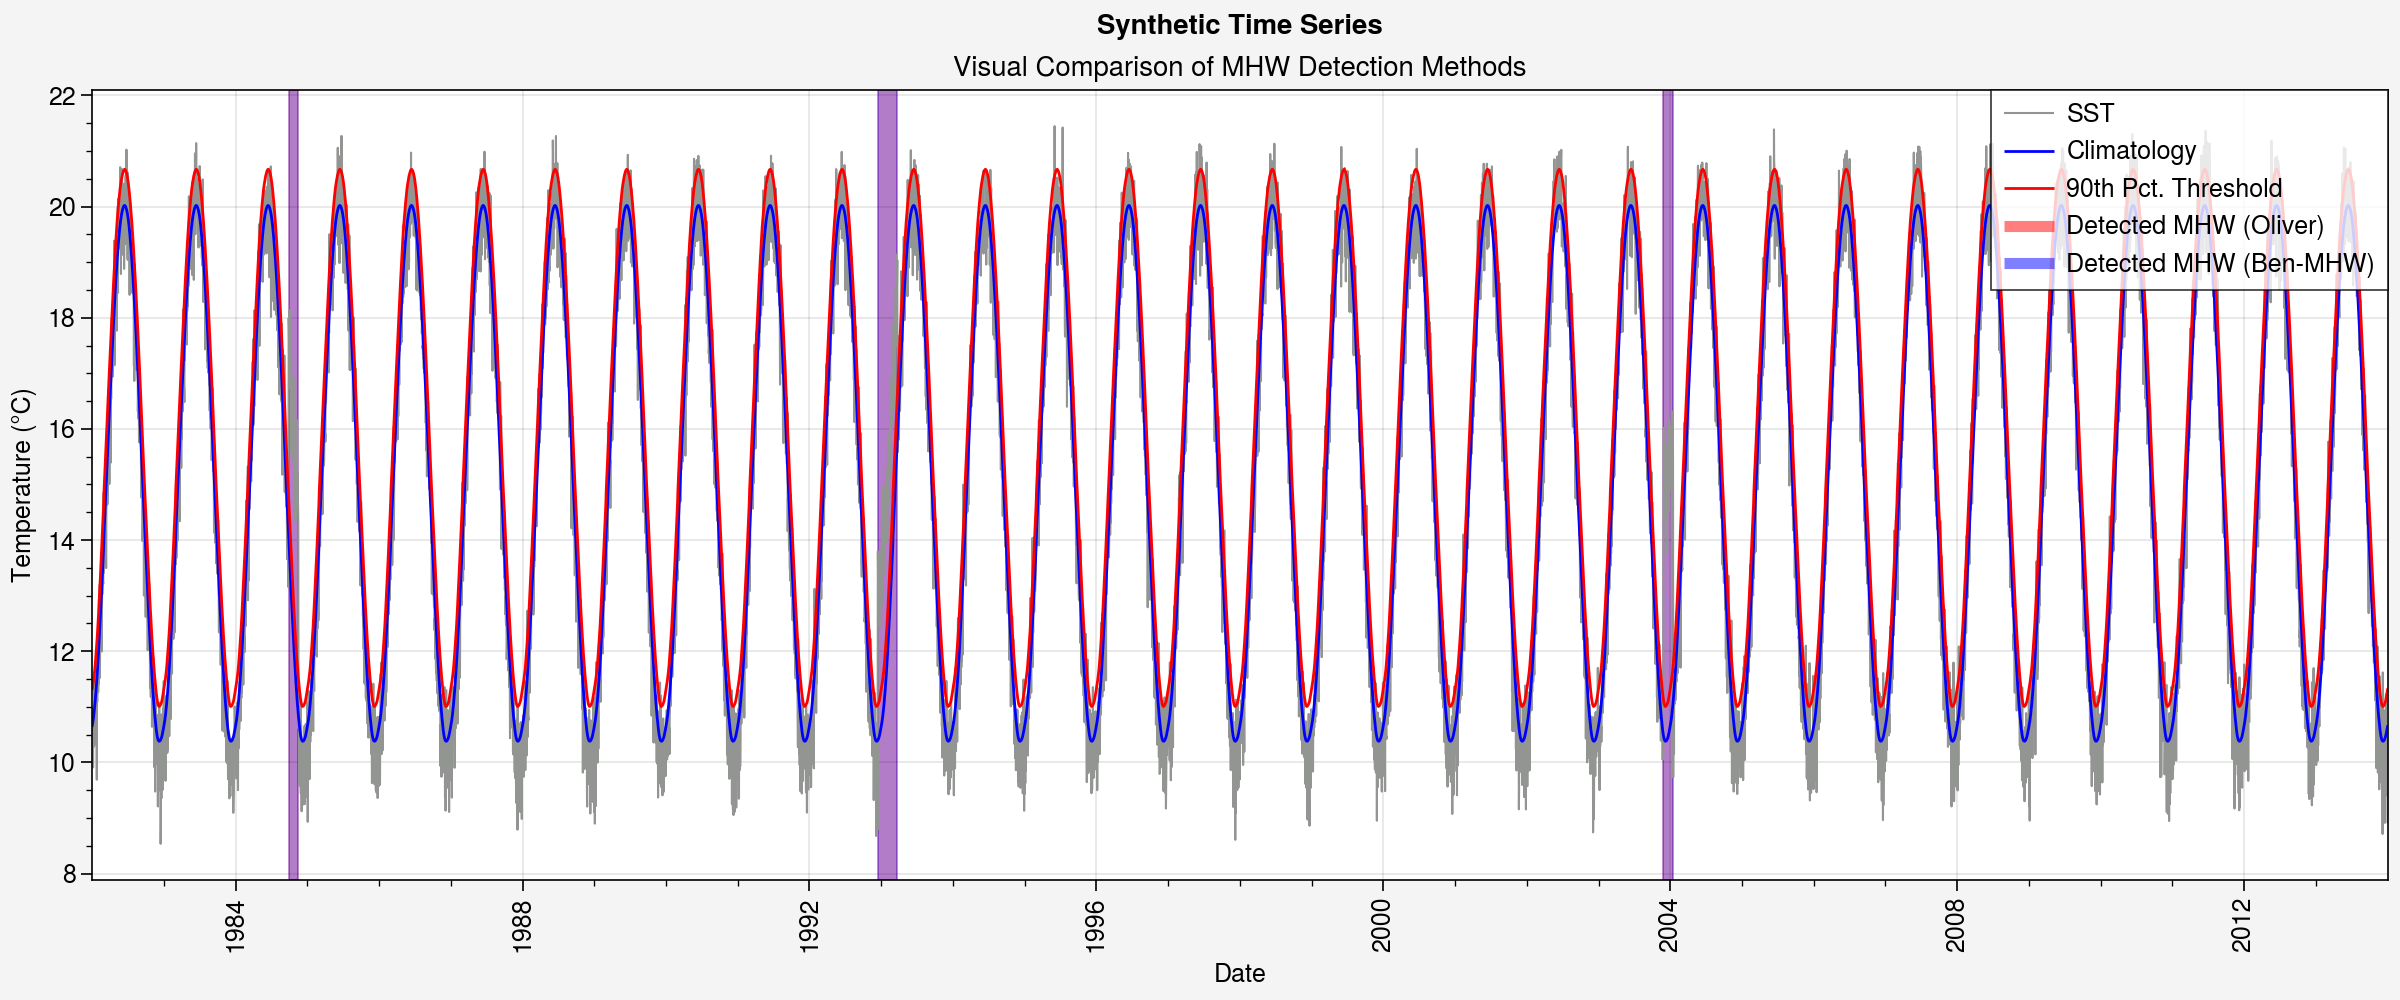

In [6]:
# Create a figure and axes for the plot
fig, ax = pplt.subplots(figsize=(12, 5), tight=True)

# Plot the full temperature time series, climatology, and threshold
ax.plot(time, temp, color='gray', lw=0.75, label='SST')
ax.plot(time, expected_clim['seas'], color='blue', lw=1, label='Climatology')
ax.plot(time, expected_clim['thresh'], color='red', lw=1, label='90th Pct. Threshold')

# Highlight the detected MHWs from both methods
# Use different colors with transparency to see the overlap
for i, event in expected_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='red', alpha=0.3)

for i, event in actual_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='blue', alpha=0.3)

# Add clear legend entries
ax.plot([], [], color='red', lw=4, alpha=0.5, label='Detected MHW (Oliver)')
ax.plot([], [], color='blue', lw=4, alpha=0.5, label='Detected MHW (Ben-MHW)')

# Format the plot
ax.format(
    title='Visual Comparison of MHW Detection Methods',
    xlabel='Date',
    ylabel='Temperature (°C)',
    suptitle='Synthetic Time Series'
)
ax.legend(ncols=1, loc='upper right')

pplt.show()

## Then compare the climatologies and thresholds between the two codes:

Calculating 366-day climatology using the ben-mhw toolbox...
Calculation complete.
Summarizing the Oliver code's daily output...
Summarizing complete.


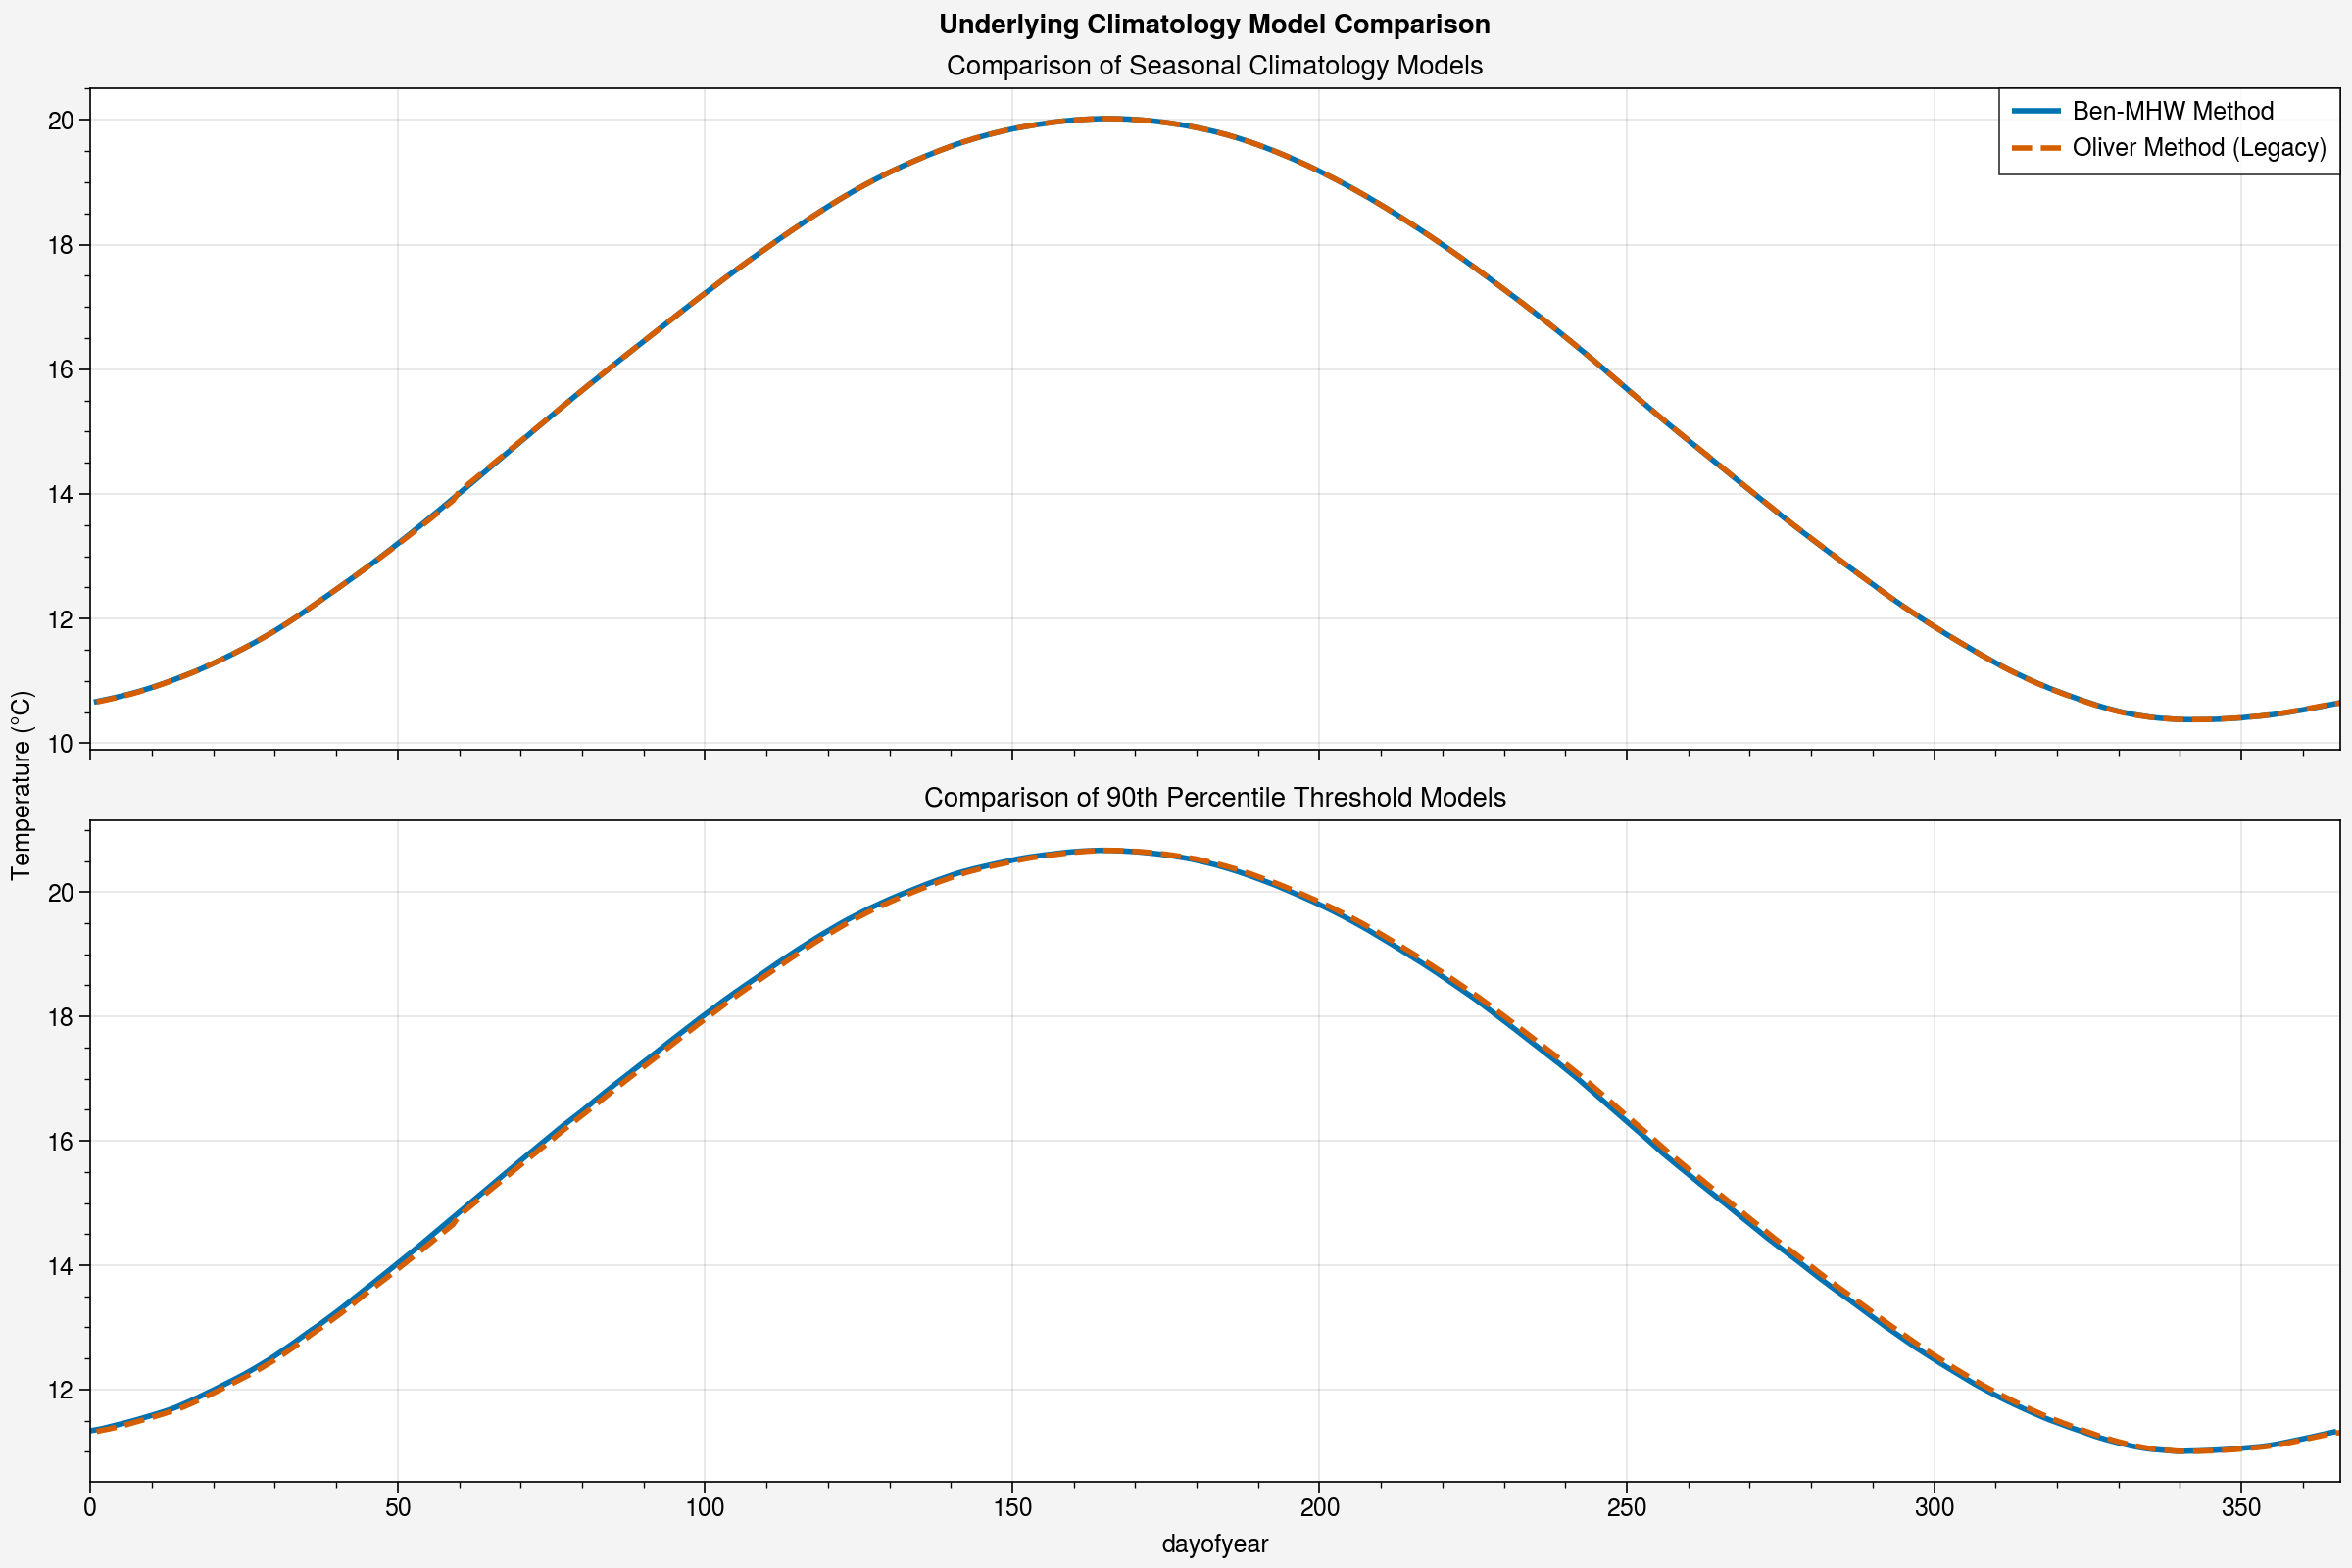

In [12]:
# --- Cell 6: The Correct Climatology Comparison ---

# 1. Calculate the 366-day summary climatology with YOUR ben-mhw code
print("Calculating 366-day climatology using the ben-mhw toolbox...")
ds_for_clim = xr.Dataset(
    data_vars={'temp': (('time',), temp)},
    coords={'time': time}
).expand_dims(['lat', 'lon'])

actual_seas_summary = ben_mhw.smoothedClima_mhw(ds_for_clim.temp).squeeze()
actual_thresh_summary = ben_mhw.smoothedThresh_mhw(ds_for_clim.temp).squeeze()
print("Calculation complete.")


# 2. Convert the Oliver code's DAILY output into a 366-day summary
print("Summarizing the Oliver code's daily output...")
# Create a temporary xarray.DataArray from the Oliver code's daily output
oliver_daily_clim = xr.DataArray(
    expected_clim['seas'], dims=['time'], coords={'time': time}
)
oliver_daily_thresh = xr.DataArray(
    expected_clim['thresh'], dims=['time'], coords={'time': time}
)

# Now, group by day-of-year and average to create the 366-day summary
expected_seas_summary = oliver_daily_clim.groupby('time.dayofyear').mean()
expected_thresh_summary = oliver_daily_thresh.groupby('time.dayofyear').mean()
print("Summarizing complete.")


# 3. Create the definitive comparison plot
fig, axs = pplt.subplots(nrows=2, figsize=(12, 8), tight=True, sharex=True)

# Plot Seasonal Climatologies
axs[0].plot(actual_seas_summary, lw=2, label='Ben-MHW Method')
axs[0].plot(expected_seas_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[0].format(
    title='Comparison of Seasonal Climatology Models',
    ylabel='Temperature (°C)'
)
axs[0].legend(ncols=1, loc='best')

# Plot 90th Percentile Thresholds
axs[1].plot(actual_thresh_summary, lw=2, label='Ben-MHW Method')
axs[1].plot(expected_thresh_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[1].format(
    title='Comparison of 90th Percentile Threshold Models',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)

fig.format(suptitle='Underlying Climatology Model Comparison')
pplt.show()

In [13]:
actual_seas_summary

<xarray.DataArray 'temp' (dayofyear: 366)>
array([10.67002616, 10.69047984, 10.71106604, 10.73315836, 10.75634945,
       10.78109088, 10.80711587, 10.8349078 , 10.86475609, 10.89600766,
       10.92864199, 10.96253472, 10.99811352, 11.03529479, 11.07309272,
       11.10928067, 11.15008353, 11.19322272, 11.2372714 , 11.28233107,
       11.32872548, 11.37657507, 11.42509804, 11.47505395, 11.52567849,
       11.57810562, 11.63208505, 11.68785317, 11.74474799, 11.80332532,
       11.86395702, 11.92637935, 11.99044481, 12.05595106, 12.12315973,
       12.191935  , 12.26055791, 12.32951258, 12.39903287, 12.46837682,
       12.53832452, 12.60900427, 12.67978204, 12.75111147, 12.82341314,
       12.8970655 , 12.97099328, 13.04700903, 13.12381517, 13.20135037,
       13.27975241, 13.35851293, 13.43726852, 13.51724758, 13.59800104,
       13.67987598, 13.76124204, 13.84319133, 13.92501356, 14.0076151 ,
       14.09020433, 14.17350238, 14.25729257, 14.34083964, 14.42414337,
       14.50709927, 14.59011167, 14.67368249, 14.75752205, 14.84101153,
       14.92381186, 15.00647201, 15.08843342, 15.17071216, 15.25353614,
       15.33608249, 15.41839737, 15.49997176, 15.58008985, 15.65973958,
       15.73931761, 15.81924823, 15.89944592, 15.97924081, 16.05790426,
       16.13599638, 16.21357255, 16.2910378 , 16.36861041, 16.4467236 ,
       16.52445651, 16.6024934 , 16.6797444 , 16.75676809, 16.83398249,
       16.91165966, 16.98897734, 17.06601857, 17.14214002, 17.21739733,
...
       13.98132888, 13.90189005, 13.82196276, 13.74245696, 13.66399831,
       13.58647234, 13.50917459, 13.43299896, 13.35760856, 13.28282716,
       13.20785185, 13.13296218, 13.05878128, 12.98501475, 12.91171417,
       12.83917865, 12.76621046, 12.69308099, 12.62015133, 12.5479819 ,
       12.47538217, 12.40358478, 12.33259605, 12.2632447 , 12.19559598,
       12.12911684, 12.0634682 , 11.99915788, 11.93613316, 11.87366502,
       11.8109661 , 11.74959132, 11.6892937 , 11.63054566, 11.57219528,
       11.51400144, 11.45674783, 11.40062735, 11.34541093, 11.29040307,
       11.23711447, 11.18661104, 11.13747965, 11.0899788 , 11.04407552,
       10.9992868 , 10.9557516 , 10.91399832, 10.87371973, 10.83507168,
       10.79823115, 10.76253027, 10.72682133, 10.6925208 , 10.65863994,
       10.62586499, 10.59478206, 10.5661047 , 10.53955713, 10.51456196,
       10.49149738, 10.47126297, 10.45285458, 10.43677411, 10.42209659,
       10.4103239 , 10.40081211, 10.39342601, 10.38711892, 10.38218165,
       10.38007615, 10.37942456, 10.37921522, 10.3803063 , 10.38224983,
       10.38563403, 10.39048454, 10.39572059, 10.40162889, 10.40869802,
       10.42009559, 10.42790995, 10.4364685 , 10.44701776, 10.45889555,
       10.47226702, 10.48687714, 10.50300209, 10.51943044, 10.53639843,
       10.55428346, 10.57244241, 10.5910664 , 10.61041982, 10.63016614,
       10.64998087])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [14]:
expected_seas_summary

<xarray.DataArray (dayofyear: 366)>
array([10.66250793, 10.6830028 , 10.70394872, 10.72579521, 10.74920406,
       10.77452613, 10.80097125, 10.8293794 , 10.85986899, 10.89155812,
       10.924889  , 10.9593152 , 10.99465565, 11.03179149, 11.0700447 ,
       11.1096176 , 11.15030969, 11.19336238, 11.23734636, 11.28235854,
       11.32872548, 11.37657507, 11.42509804, 11.47505395, 11.52567849,
       11.57810562, 11.63208505, 11.68785317, 11.74474799, 11.80332532,
       11.86395702, 11.92637935, 11.99044481, 12.05595106, 12.12315973,
       12.191935  , 12.26055791, 12.32951258, 12.39903287, 12.46837682,
       12.53832452, 12.60900427, 12.67978204, 12.75111147, 12.82239493,
       12.89382089, 12.96590773, 13.0394318 , 13.11393367, 13.18950366,
       13.26567852, 13.34272928, 13.41943376, 13.49680186, 13.57511158,
       13.6544441 , 13.73437138, 13.81421693, 13.89424499, 14.03550576,
       14.11677439, 14.19810649, 14.28003309, 14.36180497, 14.44297364,
       14.52400526, 14.60539334, 14.68711465, 14.76866581, 14.8501469 ,
       14.93133161, 15.0116848 , 15.09215035, 15.17282547, 15.25429332,
       15.33690403, 15.41908144, 15.50039724, 15.58072928, 15.66062704,
       15.7402752 , 15.82003292, 15.90015886, 15.97973657, 16.05851149,
       16.13669982, 16.21419459, 16.29166217, 16.36946834, 16.44744919,
       16.52514825, 16.60286331, 16.68016453, 16.75708545, 16.83433871,
       16.91195175, 16.98936086, 17.06621838, 17.14234399, 17.2176707 ,
...
       13.98371625, 13.9042886 , 13.82445388, 13.74513838, 13.66708003,
       13.58945919, 13.51269778, 13.43664424, 13.36128361, 13.28649122,
       13.21145949, 13.13643027, 13.0617695 , 12.98785256, 12.91434242,
       12.84107545, 12.76764494, 12.69391997, 12.62055722, 12.54771981,
       12.4749905 , 12.40331601, 12.33276937, 12.26363146, 12.19608904,
       12.12975855, 12.06432257, 12.00011042, 11.93710175, 11.87445764,
       11.8120308 , 11.75048867, 11.68969989, 11.63038315, 11.57171698,
       11.51317474, 11.45539443, 11.39855273, 11.34276047, 11.2877477 ,
       11.23451074, 11.18343306, 11.13411728, 11.08655813, 11.04024411,
       10.99505945, 10.95139476, 10.90983008, 10.86994796, 10.83129402,
       10.79402031, 10.75795649, 10.72230159, 10.68756569, 10.65362873,
       10.62083249, 10.58990325, 10.56140069, 10.53468893, 10.50962566,
       10.48708554, 10.46744293, 10.4497089 , 10.43446922, 10.42063885,
       10.4091636 , 10.40006202, 10.39309065, 10.38722847, 10.38295576,
       10.38109446, 10.38047834, 10.38051026, 10.38145079, 10.3834216 ,
       10.38703954, 10.39223029, 10.39790459, 10.40400858, 10.41132778,
       10.41950819, 10.4278316 , 10.43718248, 10.44837262, 10.46112899,
       10.47537398, 10.4911463 , 10.50764947, 10.52489492, 10.54263638,
       10.56088467, 10.5793436 , 10.59814245, 10.61766781, 10.63713755,
       10.6419831 ])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

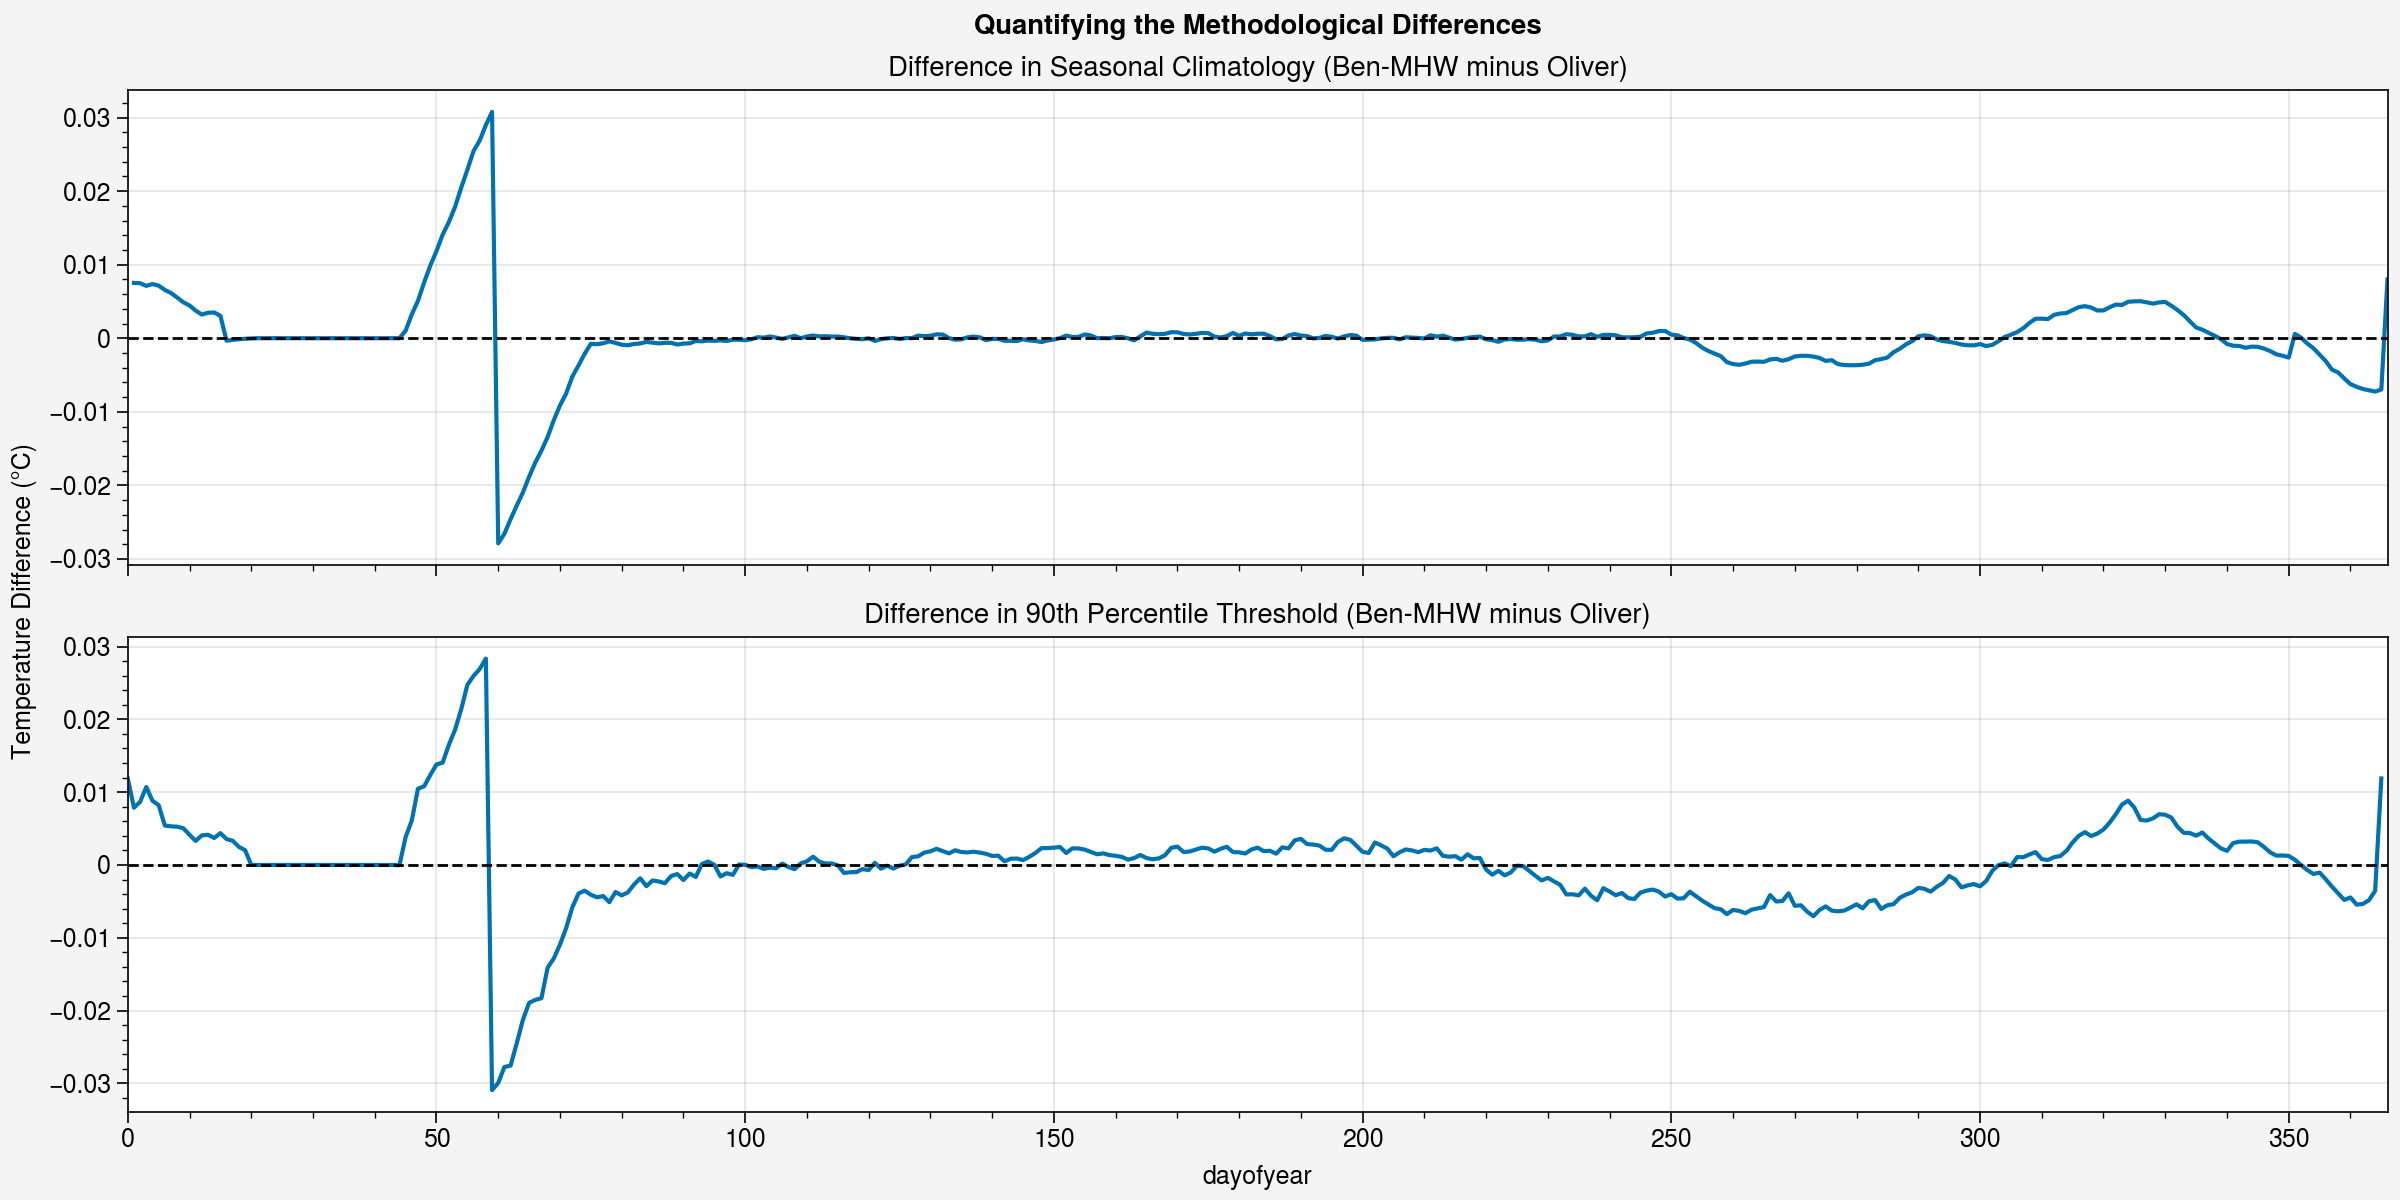

Maximum absolute difference in climatology: 0.0308 °C
Maximum absolute difference in threshold: 0.0309 °C


In [15]:
# --- Cell 7: Numerical Difference Analysis ---

# Calculate the difference between the two climatology models
climatology_difference = actual_seas_summary.values - expected_seas_summary.values

# Calculate the difference between the two threshold models
threshold_difference = actual_thresh_summary.values - expected_thresh_summary.values


# Create a new plot to visualize JUST the difference
fig, axs = pplt.subplots(nrows=2, figsize=(12, 6), tight=True, sharex=True)

# Plot the difference in seasonal climatologies
axs[0].plot(actual_seas_summary.dayofyear, climatology_difference)
axs[0].axhline(0, color='k', linestyle='--', lw=1) # Add a zero line for reference
axs[0].format(
    title='Difference in Seasonal Climatology (Ben-MHW minus Oliver)',
    ylabel='Temperature Difference (°C)'
)

# Plot the difference in 90th percentile thresholds
axs[1].plot(actual_thresh_summary.dayofyear, threshold_difference)
axs[1].axhline(0, color='k', linestyle='--', lw=1)
axs[1].format(
    title='Difference in 90th Percentile Threshold (Ben-MHW minus Oliver)',
    xlabel='Day of Year',
    ylabel='Temperature Difference (°C)'
)

fig.format(suptitle='Quantifying the Methodological Differences')
pplt.show()

# Print the maximum absolute difference to quantify the magnitude
print(f"Maximum absolute difference in climatology: {np.abs(climatology_difference).max():.4f} °C")
print(f"Maximum absolute difference in threshold: {np.abs(threshold_difference).max():.4f} °C")

Calculating RAW (unsmoothed) percentile values for each day-of-year...
Raw value calculation complete.


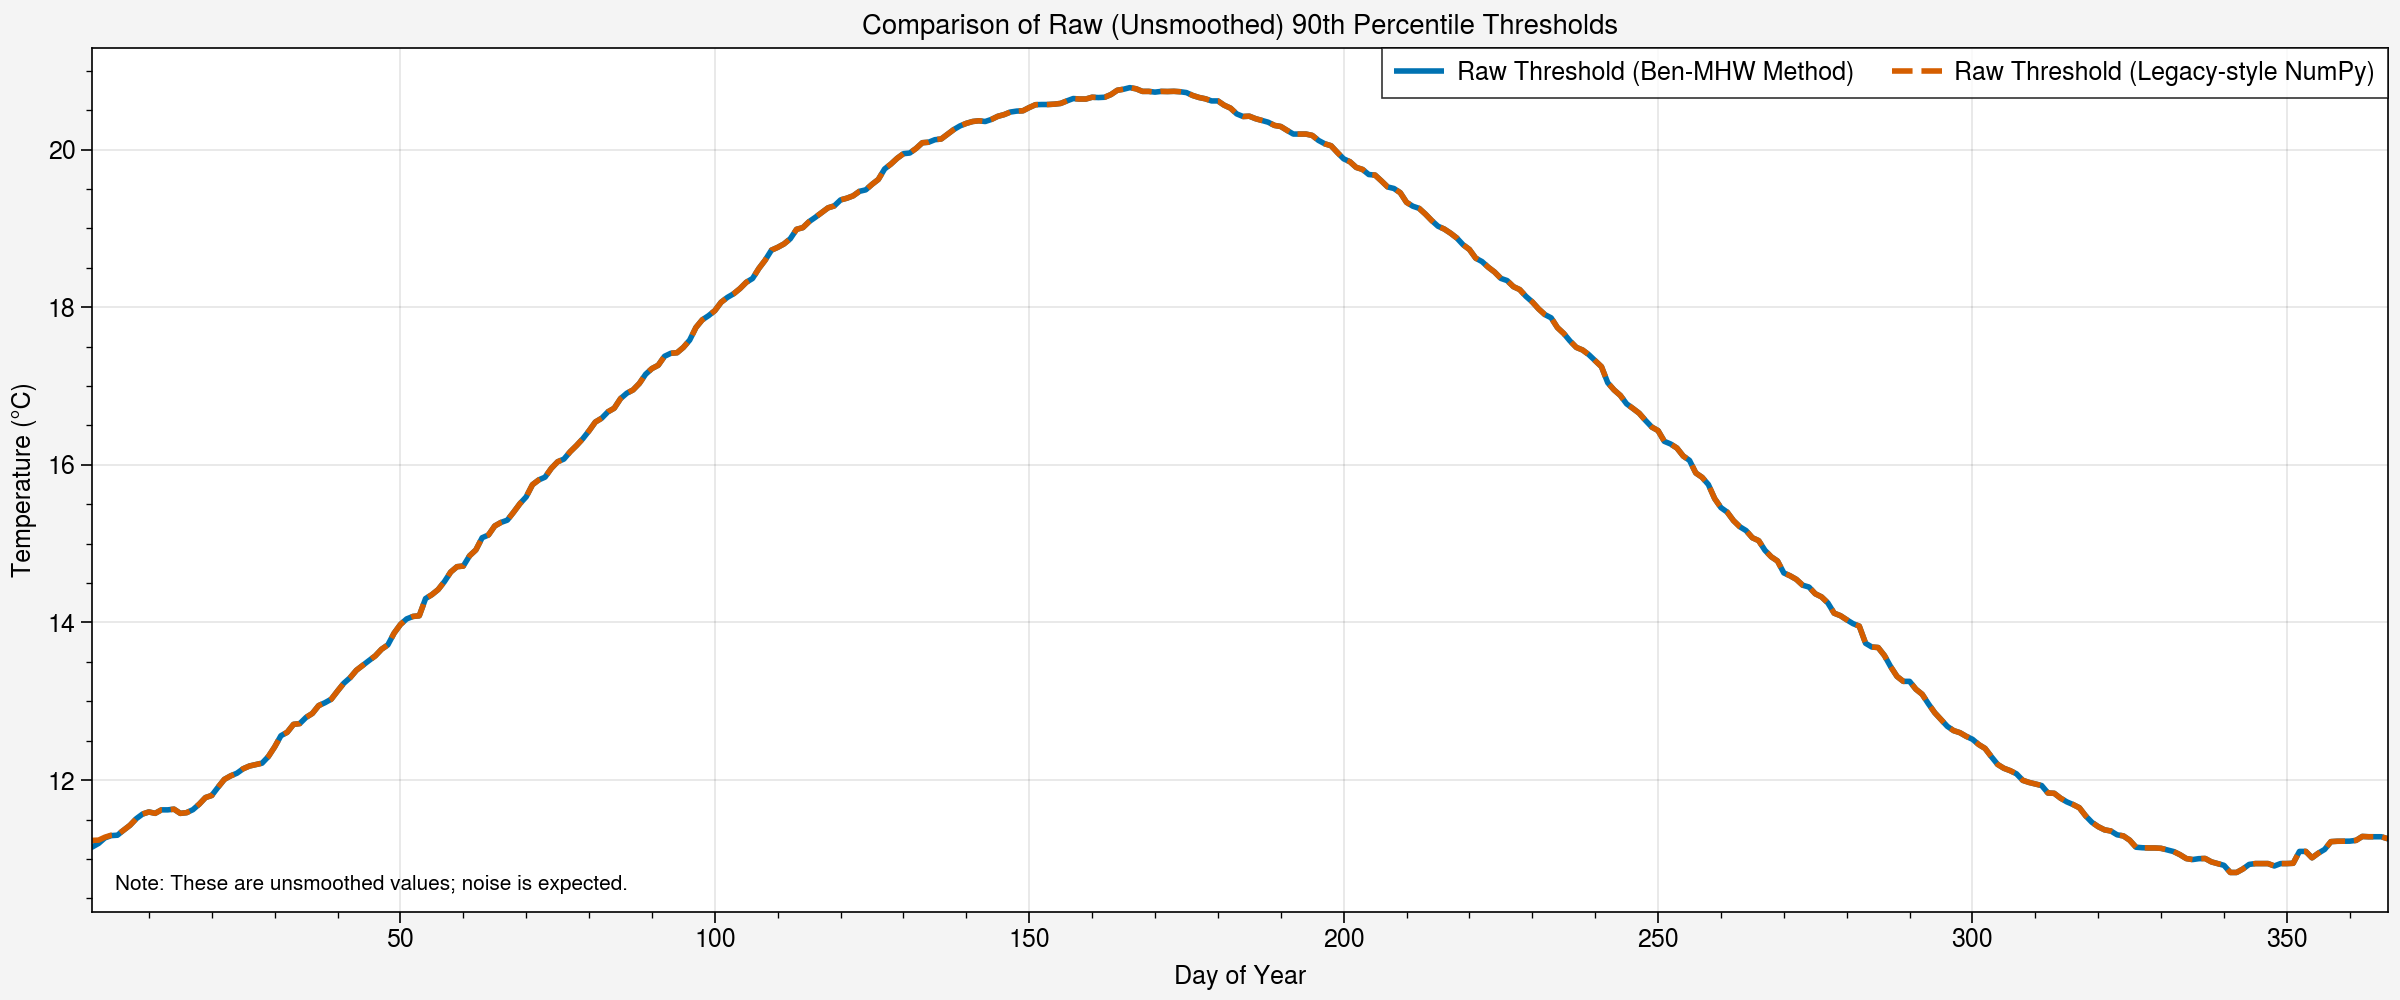

In [17]:
# --- Cell 7: Due Diligence - Raw (Unsmoothed) Threshold Analysis (Corrected) ---

print("Calculating RAW (unsmoothed) percentile values for each day-of-year...")

# We need the dayofyear array from our time coordinate for grouping
doy = ds_for_clim.time.dt.dayofyear

# --- Method 1: Replicate your ben-mhw logic (using xarray) ---
raw_actual_thresh = []
for day in range(1, 367):
    if day <= 366 - 5:
        window = ds_for_clim.temp.where((doy >= day - 5) & (doy <= day + 5), drop=True)
    else:
        window = ds_for_clim.temp.where((doy >= day - 5) | (doy <= (day + 5) % 366), drop=True)
    
    percentile_val = window.quantile(0.9, dim='time', skipna=False)
    raw_actual_thresh.append(percentile_val.item())

# --- Method 2: Replicate the legacy logic (using basic NumPy) ---
raw_expected_thresh = []
temp_np = ds_for_clim.temp.values.flatten()
doy_np = doy.values

for day in range(1, 367):
    days_in_window = np.arange(day - 5, day + 6)
    days_in_window[days_in_window < 1] += 366
    days_in_window[days_in_window > 366] -= 366
    
    indices_in_window = np.isin(doy_np, days_in_window)
    percentile_val = np.percentile(temp_np[indices_in_window], 90)
    raw_expected_thresh.append(percentile_val)

print("Raw value calculation complete.")

# --- Create the comparison plot ---
fig, ax = pplt.subplots(figsize=(12, 5), tight=True)

day_of_year_axis = np.arange(1, 367)
ax.plot(day_of_year_axis, raw_actual_thresh, lw=2, label='Raw Threshold (Ben-MHW Method)')
ax.plot(day_of_year_axis, raw_expected_thresh, lw=2, linestyle='--', label='Raw Threshold (Legacy-style NumPy)')
ax.plot([], [], lw=0)

# The proplot equivalent of 'axes fraction' is just 'axes'
ax.text(0.01, 0.02, 'Note: These are unsmoothed values; noise is expected.', transform='axes', ha='left', va='bottom', fontsize='small') # <--- THIS IS THE CORRECTED LINE

ax.format(
    title='Comparison of Raw (Unsmoothed) 90th Percentile Thresholds',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)
ax.legend(loc='best')
pplt.show()

Isolating and comparing the smoothing function itself...
Smoothing comparison complete.


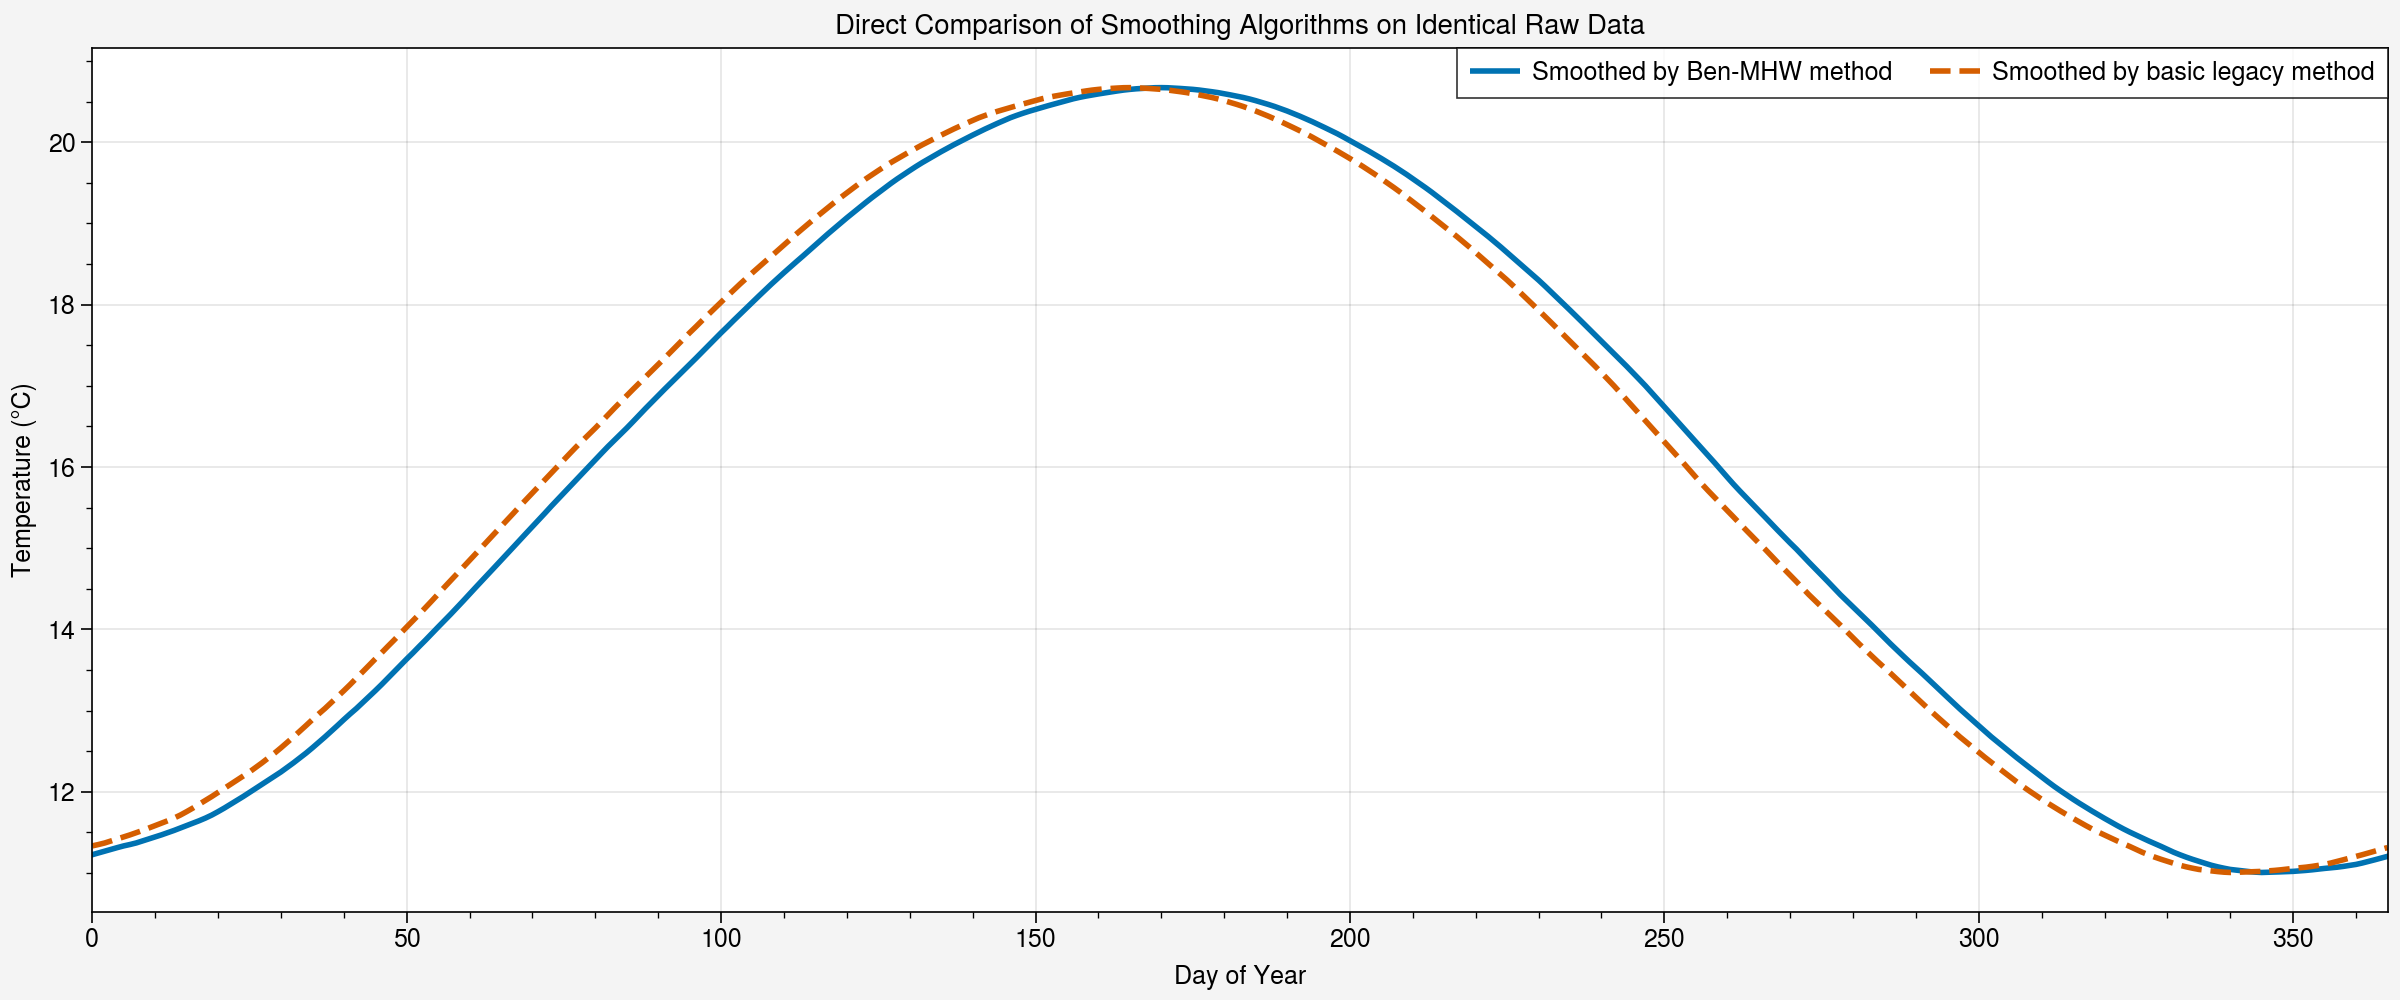

In [18]:
# --- Cell 8: The Final Test - Isolating the Smoothing Algorithm ---

print("Isolating and comparing the smoothing function itself...")

# Let's use the 'raw_expected_thresh' as the identical input for both smoothers
input_raw_thresholds = np.array(raw_expected_thresh)

# --- Smoothing Method 1: Your ben-mhw implementation ---
# We replicate the logic from your smoothedThresh_mhw function
# Convert to an xarray.DataArray to use xarray's tools
thresh_da = xr.DataArray(input_raw_thresholds, dims=['dayofyear'], coords={'dayofyear': np.arange(1, 367)})
stacked_actual = xr.concat([thresh_da, thresh_da, thresh_da], dim='year').stack(time=('year', 'dayofyear')).roll(time=5)
smoothed_actual = stacked_actual.rolling(time=31, min_periods=1, center=True).mean()
final_actual_smooth = smoothed_actual.where(smoothed_actual.year==1, drop=True).drop('year').rename({'time':'dayofyear'})


# --- Smoothing Method 2: A simplified, pure legacy-style implementation ---
# We use pandas which has a rolling mean closer to older implementations
s = pd.Series(np.concatenate([input_raw_thresholds] * 3))
# Note: No .roll() command here
final_expected_smooth = s.rolling(window=31, min_periods=1, center=True).mean().iloc[366:366*2].values

print("Smoothing comparison complete.")

# --- Create the comparison plot ---
fig, ax = pplt.subplots(figsize=(12, 5), tight=True)

ax.plot(final_actual_smooth.dayofyear, final_actual_smooth.values, lw=2, label='Smoothed by Ben-MHW method')
ax.plot(final_actual_smooth.dayofyear, final_expected_smooth, lw=2, linestyle='--', label='Smoothed by basic legacy method')

ax.format(
    title='Direct Comparison of Smoothing Algorithms on Identical Raw Data',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)
ax.legend(loc='best')
pplt.show()

In [19]:
# --- Cell 9: Exporting the Smoothed Numerical Data ---

print("="*50)
print(" Smoothed Data from Your Ben-MHW Method")
print("="*50)
# We print the .values to get the raw numpy array
print(final_actual_smooth.values)


print("\n\n" + "="*50)
print(" Smoothed Data from the Basic Legacy-Style Method")
print("="*50)
print(final_expected_smooth)

 Smoothed Data from Your Ben-MHW Method
[11.2264397  11.24841865 11.27138133 11.29363937 11.31418309 11.33490108
 11.35197283 11.37129413 11.39594775 11.41956922 11.44503409 11.47049648
 11.4972553  11.52505257 11.55468735 11.58512562 11.61452944 11.64463913
 11.6774606  11.71420201 11.75633689 11.80057304 11.84794167 11.8944497
 11.94267203 11.99226579 12.0432166  12.09335823 12.14224622 12.19257217
 12.24524224 12.30073519 12.3578602  12.41697321 12.47777835 12.54221692
 12.60908457 12.67650742 12.74650504 12.81730677 12.88955977 12.95944228
 13.02639586 13.09895334 13.17201902 13.24532737 13.32077545 13.39958133
 13.47998038 13.55792533 13.63614996 13.71217222 13.7917904  13.86927786
 13.95013686 14.02991645 14.10900623 14.18814773 14.26958356 14.35238703
 14.43683339 14.5200335  14.60210684 14.68474605 14.76807081 14.85052856
 14.93408058 15.01743346 15.10179221 15.18459483 15.26746299 15.34956807
 15.4332949  15.51823569 15.60003719 15.68247496 15.76418785 15.8452892
 15.92622943 